In [ ]:
'''
                ***** LIME AND SHAP Explanation *****
                
This notebook provides the LIME and SHAP implementation for Classification based models (Loan Eligibility). 

A. LIME Explanation
B. SHAP Explanation

'''

In [6]:
from sklearn.datasets import load_boston
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
import pickle
from sklearn.linear_model import LinearRegression, LogisticRegression
import shap
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [14]:
df = pd.read_csv('loanEligibility.csv', encoding='latin1')

df["sex"] = df["sex"].map({"Male": 0, "Female":1})
df["marital-status"] = df["marital-status"].replace(['Never-married','Divorced','Separated','Widowed'], 'Single')
df["marital-status"] = df["marital-status"].replace(['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'], 'Married')
df["marital-status"] = df["marital-status"].map({"Married":1, "Single":0})
df["marital-status"] = df["marital-status"].astype(int)

# Drop the data we don't want to use
df.drop(labels=["workclass","education","occupation","relationship","race","native-country"], axis = 1, inplace = True)
feature_names = df.columns
df.head()

,age,fnlwgt,education-num,marital-status,sex,current-worth,outstanding-credit,hours-per-week,loan-eligibility
0,39,77516,13,0,0,2174,0,40,ineligible
1,50,83311,13,1,0,0,0,13,ineligible
2,38,215646,9,0,0,0,0,40,ineligible
3,53,234721,7,1,0,0,0,40,ineligible
4,28,338409,13,1,1,0,0,40,ineligible


In [20]:
array = df.values
X = array[:,0:8]
Y = array[:,8]

validation_size = 0.20
seed = 7

X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y,
    test_size=validation_size,random_state=seed)

lrmodel = LogisticRegression().fit(X_train, Y_train)
predictions = lrmodel.predict(X_validation)
print("Accuracy: %s%%" % (100*accuracy_score(Y_validation, predictions)))

Accuracy: 79.44111776447106%


C:\Users\618757\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [17]:
'''
            **** LIME EXPLANATION ****
A. This Section provides Lime LimeTabularExplainer implementation
B. You can defined the num_feature attribute depends on for how many input features you would like to get explanation
   Max value of this attribute should be actual number of input features.

'''

categorical_features = np.argwhere(np.array([len(set(X_train[:,x])) for x in range(X_train.shape[1])]) <= 20).flatten()

#no need to mention class_name'labels in regression use case
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, 
                categorical_features=categorical_features, class_names=lrmodel.classes_, kernel_width=3)

explanation_record_entries = []
for i in range(3): # for i in range(len(X_validation))
    exp = explainer.explain_instance(X_validation[i], lrmodel.predict_proba, num_features=len(feature_names), labels=[0, 1])
    lim = {
        "trueClass": Y_validation[i],
        "predictedClass": predictions[i],
        "explanation":  exp.as_list(label=1)
    }
    explanation_record_entries.append(lim)

explanation_record_entries

[{'trueClass': 'ineligible',
  'predictedClass': 'ineligible',
  'explanation': [('current-worth <= 0.00', 0.4826585594386617),
   ('outstanding-credit > 0.00', -0.32005954485701194),
   ('fnlwgt <= 117564.25', -0.09516021385532072),
   ('hours-per-week <= 40.00', -0.027844116048099422),
   ('education-num=10', 0.005685494284669929),
   ('37.00 < age <= 48.00', 0.004495708938208382),
   ('marital-status=0', 0.0026322379757468695),
   ('sex=1', 0.0009339483539154824)]},
 {'trueClass': 'eligible',
  'predictedClass': 'ineligible',
  'explanation': [('current-worth <= 0.00', 0.46028128404567326),
   ('outstanding-credit <= 0.00', 0.30624075882122087),
   ('fnlwgt <= 117564.25', -0.09612935005521567),
   ('hours-per-week > 45.00', 0.027560991288941735),
   ('education-num=13', 0.008116943095912384),
   ('37.00 < age <= 48.00', 0.005399473337130118),
   ('sex=0', 0.005005874052880033),
   ('marital-status=0', 0.002119175018677374)]},
 {'trueClass': 'ineligible',
  'predictedClass': 'ineligible',
  'explanation': [('current-worth <= 0.00', 0.4973404183082082),
   ('outstanding-credit <= 0.00', 0.3029309611596672),
   ('fnlwgt <= 117564.25', -0.09431669770134275),
   ('age <= 28.00', -0.03320018169405706),
   ('hours-per-week <= 40.00', -0.025786881031867902),
   ('marital-status=1', 0.0021111399941992244),
   ('education-num=10', 0.001205665702409232),
   ('sex=0', 0.001064826902967745)]}]

In [18]:
'''
            **** SHAP EXPLANATION ****
A. This Section provides SHAP  implementation

'''

algorithm = 'logisticRegression'
if algorithm in ['linearRegression', 'logisticRegression', 'naivebayes', 'svm']:
    explainer = shap.LinearExplainer(lrmodel, X_train, feature_dependence="independent")
elif algorithm in ['decisionTree', 'randomForest', 'gradientBoosting']:
    explainer = shap.TreeExplainer(lrmodel)

shap_values = explainer.shap_values(X_validation)
shap_sum = np.abs(shap_values).mean(axis=0)

importance_df = pd.DataFrame([feature_names, shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df = importance_df[importance_df['shap_importance'] > 0.10]
importance_df.head()

,column_name,shap_importance
5,current-worth,0.690513
1,fnlwgt,0.278477
6,outstanding-credit,0.132242


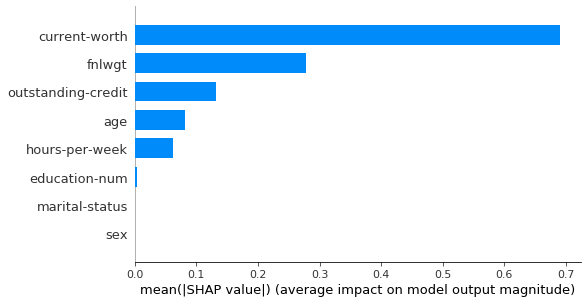

In [19]:
shap.summary_plot(shap_values, X_validation, feature_names=feature_names, plot_type="bar")